In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

C:\Users\STANLEY\AppData\Local\Temp\ipykernel_15672\1827467380.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# I will keep the resulting plots
%matplotlib inline

# Enable Jupyter Notebook's intellisense
# %config IPCompleter.greedy=True

# We want to see whole content (non-truncated)
pd.set_option('display.max_colwidth', None)

In [4]:
train_data_file_path = os.path.join('artifacts', "train.csv")
train_data = pd.read_csv(train_data_file_path)

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
train_data.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

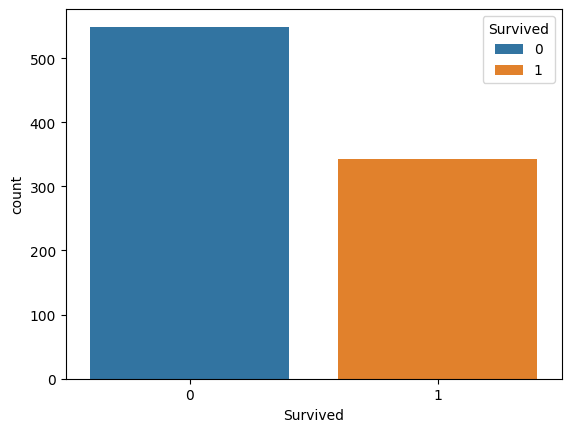

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


In [8]:
# Visualize with a countplot
sns.countplot(x="Survived", data=train_data, hue="Survived")
plt.show()

# Print the proportions
print(train_data["Survived"].value_counts(normalize=True))

In [9]:
def visualisation_wrt_survival(df, feature_list):

    for feature in feature_list:
        # Visualize with a countplot
        sns.countplot(x=feature, hue="Survived", data=df)
        plt.title(f"{feature} with respect to Survived")
        plt.show()

        print(f"Value counts of {feature} feature")
        print(df[feature].value_counts())

        print(f"Proportion of people who survived for each {feature} feature value")
        # print(train_data["Survived"].groupby(train_data[feature]).mean())
        print(df[[feature, "Survived"]].groupby([feature], as_index=False).mean().sort_values(by='Survived', ascending=False))
        print(f"*******************************************************************************************")



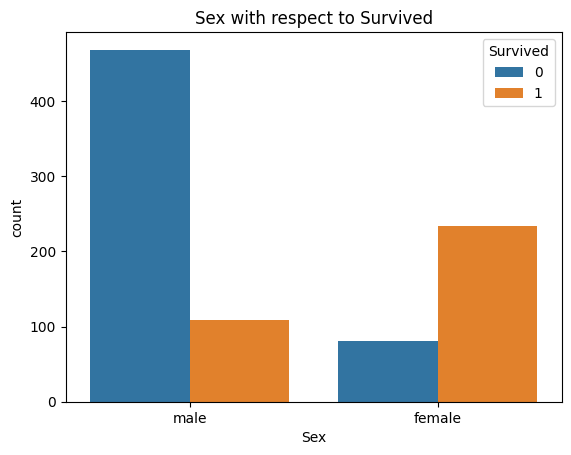

Value counts of Sex feature
Sex
male      577
female    314
Name: count, dtype: int64
Proportion of people who survived for each Sex feature value
      Sex  Survived
0  female  0.742038
1    male  0.188908
*******************************************************************************************


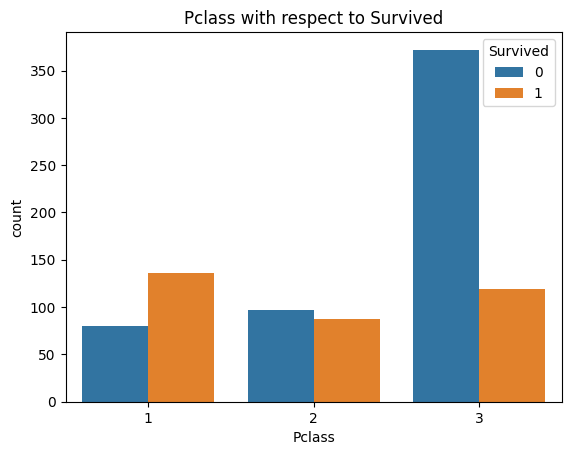

Value counts of Pclass feature
Pclass
3    491
1    216
2    184
Name: count, dtype: int64
Proportion of people who survived for each Pclass feature value
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
*******************************************************************************************


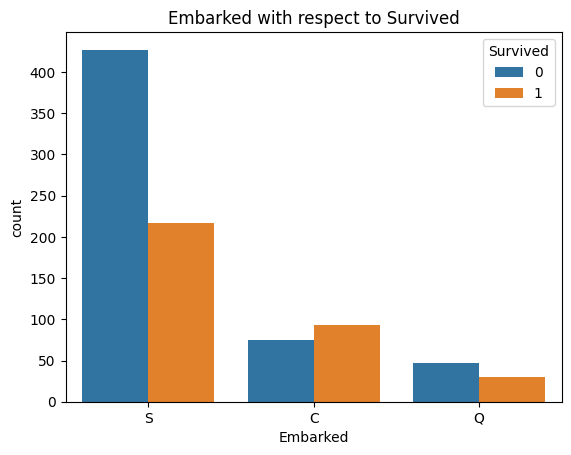

Value counts of Embarked feature
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64
Proportion of people who survived for each Embarked feature value
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957
*******************************************************************************************


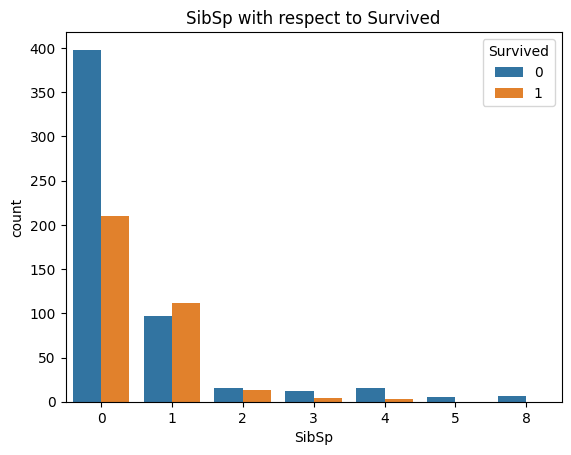

Value counts of SibSp feature
SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64
Proportion of people who survived for each SibSp feature value
   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
*******************************************************************************************


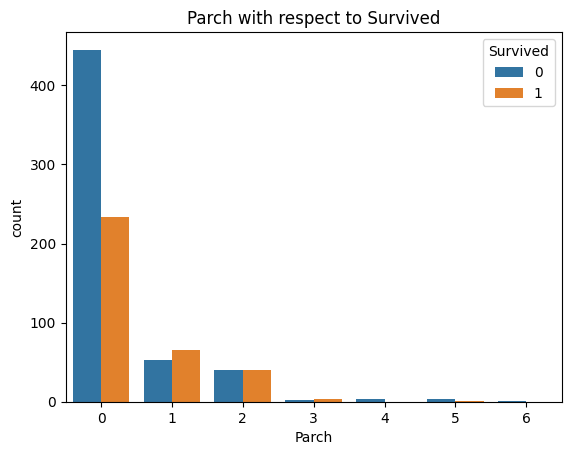

Value counts of Parch feature
Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64
Proportion of people who survived for each Parch feature value
   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000
*******************************************************************************************


In [10]:
cat_features_to_visualize = ["Sex", "Pclass", "Embarked", "SibSp", "Parch"]
visualisation_wrt_survival(train_data, cat_features_to_visualize)

In [11]:
def custom_preprocessor(df):

    # Feature Generation

    # Get titles
    df["Title"] = df['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

    # Mapping French Madame and Madammoisel to Mrs and Miss respectively
    # Mapping Don and Dona to Sir and Madam respectively 
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].replace('Dona', 'Lady')
    df['Title'] = df['Title'].replace('Don', 'Sir')

    # Family Size
    df["Fsize"] = df["SibSp"] + df["Parch"]

    # Ticket first letters
    df["Ticket"] = df["Ticket"].apply(lambda x: str(x)[0])



    return df

In [13]:
data_new = custom_preprocessor(train_data)
data_new.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Fsize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,P,71.2833,C85,C,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,S,7.9250,NaN,S,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,1,53.1000,C123,S,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,3,8.0500,NaN,S,Mr,0


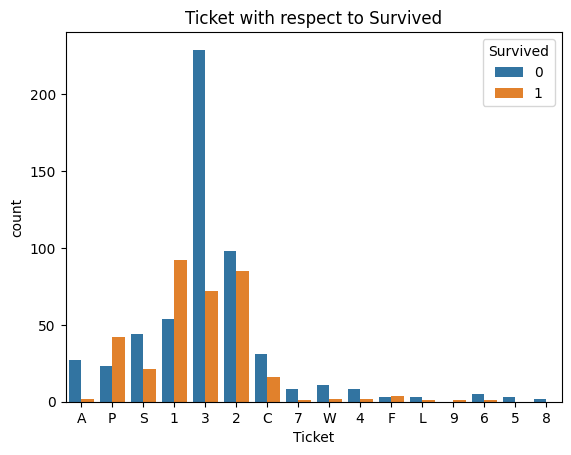

Value counts of Ticket feature
Ticket
3    301
2    183
1    146
P     65
S     65
C     47
A     29
W     13
4     10
7      9
F      7
6      6
L      4
5      3
8      2
9      1
Name: count, dtype: int64
Proportion of people who survived for each Ticket feature value
   Ticket  Survived
8       9  1.000000
13      P  0.646154
0       1  0.630137
11      F  0.571429
1       2  0.464481
10      C  0.340426
14      S  0.323077
12      L  0.250000
2       3  0.239203
3       4  0.200000
5       6  0.166667
15      W  0.153846
6       7  0.111111
9       A  0.068966
4       5  0.000000
7       8  0.000000
*******************************************************************************************


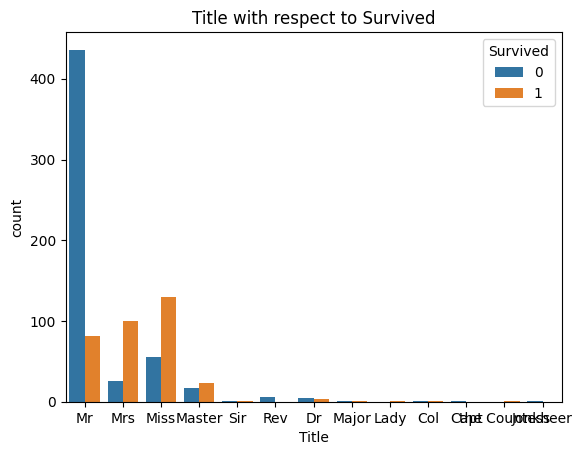

Value counts of Title feature
Title
Mr              517
Miss            185
Mrs             126
Master           40
Dr                7
Rev               6
Sir               2
Major             2
Col               2
Lady              1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64
Proportion of people who survived for each Title feature value
           Title  Survived
4           Lady  1.000000
12  the Countess  1.000000
9            Mrs  0.793651
7           Miss  0.702703
6         Master  0.575000
1            Col  0.500000
5          Major  0.500000
11           Sir  0.500000
2             Dr  0.428571
8             Mr  0.156673
0           Capt  0.000000
3       Jonkheer  0.000000
10           Rev  0.000000
*******************************************************************************************


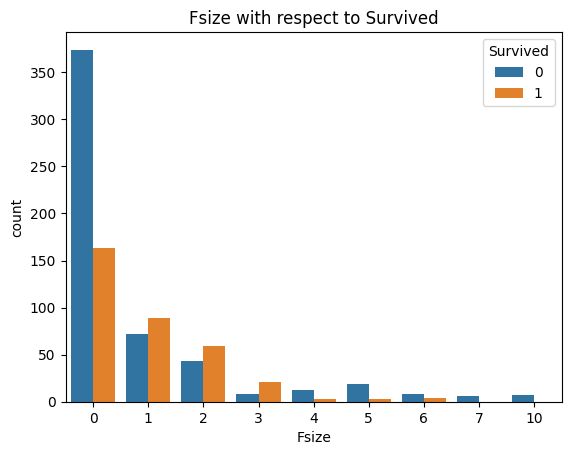

Value counts of Fsize feature
Fsize
0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: count, dtype: int64
Proportion of people who survived for each Fsize feature value
   Fsize  Survived
3      3  0.724138
2      2  0.578431
1      1  0.552795
6      6  0.333333
0      0  0.303538
4      4  0.200000
5      5  0.136364
7      7  0.000000
8     10  0.000000
*******************************************************************************************


In [14]:
visualisation_wrt_survival(data_new, ["Ticket", "Title", "Fsize"])

In [15]:
test_data_file_path = os.path.join('artifacts', "test.csv")
test_data = pd.read_csv(test_data_file_path)
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [16]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [17]:
# Final segragation of features because some integer columns are categorical columns
num_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Fsize']
cat_features = ['Sex', 'Ticket', 'Embarked','Title']

In [18]:
# Define the preprocessing steps for numerical and categorical features
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [19]:
# Combine the preprocessing steps for numerical and categorical features
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
],remainder='drop')

In [20]:
def training(df, feature_transformers):

    classifiers = {
        "Random Forest": RandomForestClassifier(),
        "XGBoost": XGBClassifier(),
        "KNN": KNeighborsClassifier(),
        "LogReg": LogisticRegression(),
        "SVM": SVC()
    }

    classifier_params = {
        "Random Forest": {
            'clf__max_depth': np.arange(3,7,1),
            'clf__n_estimators': np.arange(50,250,100)
        },
        "XGBoost": {
            'clf__learning_rate': np.arange(0.05, 1, 0.05),
            'clf__max_depth': np.arange(3,7,1),
            'clf__n_estimators': np.arange(50,250,100)
        },
        "KNN": {
            'clf__n_neighbors': [3, 5, 7, 9],
            'clf__weights': ['uniform', 'distance'],
            'clf__algorithm': ['auto', 'brute'],
        },
        "LogReg": {
            'clf__penalty': ['l1', 'l2'],
            'clf__C': [0.001, 0.01, 0.1, 1, 10],
            'clf__solver': ['liblinear', 'saga'],
        },
        "SVM": {
            'clf__C': [0.001, 0.01, 0.1, 1, 10],
            'clf__kernel': ['linear', 'rbf', 'poly'],
            'clf__gamma': ['scale', 'auto'],
        }

    }

    model_report = {}

    for key in classifiers:
        # Combine the preprocessor and model into a single pipeline
        print(f" Starting Preprocessing, Feature Engineering and Model Initialization for {key} Classifier")
        pipeline = Pipeline(steps=[
            ('custom_preprocessing', FunctionTransformer(func=custom_preprocessor)),
            ('preprocessor', feature_transformers),
            ('clf', classifiers[key])
        ])

        print(f"Starting Hyper-parameter selection and Model Training with Cross-Validation for {key}")
        model = GridSearchCV(estimator=pipeline, param_grid=classifier_params[key], scoring='accuracy', cv=5, verbose=False)
        model.fit(df.drop(['Survived'], axis=1), df['Survived'])
        print(f"Training completed for {key}. Cross-Validation Acurracy for best Model is {model.best_score_}.")
        
        print(f"Saving best model artifacts for {key}.")
        model_report_list = []
        model_report_list.append(model.best_score_) 
        model_report_list.append(model.best_params_)
        model_report_list.append(model.best_estimator_)

        model_report[key] = model_report_list 
        print(f"Save successful for {key}.")

    print(f"Collating results for Models in a Dataframe")
    model_report_df = pd.DataFrame.from_dict(model_report, orient='index',
                       columns=['best_score_cv', 'best_params', 'best_estimator'])
    model_report_df = model_report_df.sort_values("best_score_cv", ascending=False)
    print(model_report_df.drop(['best_estimator'], axis=1))
    best_model = model_report_df["best_estimator"].values[0]
    print(f"The best model is {model_report_df.index.values[0]} with hyper-parameters {model_report_df.best_params.values[0]}")
    print(f"Training Complete")
    return best_model, model_report_df.drop(['best_estimator'], axis=1)



In [21]:
best_model, model_report_df = training(train_data, preprocessor)

 Starting Preprocessing, Feature Engineering and Model Initialization for Random Forest Classifier
Starting Hyper-parameter selection and Model Training with Cross-Validation for Random Forest
Training completed for Random Forest. Cross-Validation Acurracy for best Model is 0.8282593685267716.
Saving best model artifacts for Random Forest.
Save successful for Random Forest.
 Starting Preprocessing, Feature Engineering and Model Initialization for XGBoost Classifier
Starting Hyper-parameter selection and Model Training with Cross-Validation for XGBoost
Training completed for XGBoost. Cross-Validation Acurracy for best Model is 0.8372606867114432.
Saving best model artifacts for XGBoost.
Save successful for XGBoost.
 Starting Preprocessing, Feature Engineering and Model Initialization for KNN Classifier
Starting Hyper-parameter selection and Model Training with Cross-Validation for KNN
Training completed for KNN. Cross-Validation Acurracy for best Model is 0.8182286108844391.
Saving best

c:\Users\STANLEY\Desktop\titanic_disaster_prediction\titanic_prediction_venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\STANLEY\Desktop\titanic_disaster_prediction\titanic_prediction_venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\STANLEY\Desktop\titanic_disaster_prediction\titanic_prediction_venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\STANLEY\Desktop\titanic_disaster_prediction\titanic_prediction_venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\STANLEY\Desktop\titanic_disaster_prediction\titanic_prediction_venv\Lib

Training completed for LogReg. Cross-Validation Acurracy for best Model is 0.822666499278137.
Saving best model artifacts for LogReg.
Save successful for LogReg.
 Starting Preprocessing, Feature Engineering and Model Initialization for SVM Classifier
Starting Hyper-parameter selection and Model Training with Cross-Validation for SVM
Training completed for SVM. Cross-Validation Acurracy for best Model is 0.8361182599962339.
Saving best model artifacts for SVM.
Save successful for SVM.
Collating results for Models in a Dataframe
               best_score_cv  \
XGBoost             0.837261   
SVM                 0.836118   
Random Forest       0.828259   
LogReg              0.822666   
KNN                 0.818229   

                                                                                best_params  
XGBoost          {'clf__learning_rate': 0.45, 'clf__max_depth': 3, 'clf__n_estimators': 50}  
SVM                               {'clf__C': 1, 'clf__gamma': 'auto', 'clf__kernel': '

In [22]:
model_report_df

,best_score_cv,best_params
XGBoost,0.837261,"{'clf__learning_rate': 0.45, 'clf__max_depth': 3, 'clf__n_estimators': 50}"
SVM,0.836118,"{'clf__C': 1, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}"
Random Forest,0.828259,"{'clf__max_depth': 6, 'clf__n_estimators': 150}"
LogReg,0.822666,"{'clf__C': 1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}"
KNN,0.818229,"{'clf__algorithm': 'auto', 'clf__n_neighbors': 5, 'clf__weights': 'uniform'}"


In [25]:
best_model_model = pickle.load(open('titanic_disaster_model.pkl', 'rb'))

In [23]:
predictions = best_model.predict(test_data)

In [24]:
submissions =pd.DataFrame({'PassengerId' : test_data.PassengerId, 'Survived' : predictions})
submissions.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
